** What I want to do:** In the previous iteration, I increased my training set by reducing validation subjects to 3. I'll keep this setup. But this time, I want to check whether my predicted probabilities were too sure of themselves, and were consequently getting penalised by the log loss cost function.

I'll rerun all the steps, but save weights under different names.

## Step 1: Reset train and test data

Since I'm continuing with the 3 subject model, I can retain my pre-processing setup from the previous iteration...So this means I can skip steps 1 and 2

## Step 2 - Split images into training, test, validation and sample sets

In [1]:
# get image list
%cd data/
import pandas as pd
df_imglist = pd.read_csv('driver_imgs_list.csv')

/home/ubuntu/distracted_driver/data


## Step 3: Train vgg model

In [2]:
%cd ..

/home/ubuntu/distracted_driver


In [3]:
# import utilities and packages
%matplotlib inline

from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from datetime import datetime
import re

import utils; reload(utils)
from utils import plots
from utils import save_array, load_array

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [4]:
# define locations for training, validation, test and sample sets
data_dir = "data"
train_path = "data/train/"
test_path = "data/test/"
validation_path = "data/valid/"
sample_train_path = "data/sample/train/"
sample_validation_path = "data/sample/valid/"
results_path = "data/results/"

In [5]:
batch_size = 64

In [6]:
# import the vgg16 model

#import
import vgg16; reload(vgg16)
from vgg16 import Vgg16

#instantiate
vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In subsequent iterations, finetune one level below the final layer and see if the result improves. 

If it does, go one level lower.

Also, compute log loss on validation set to see how strong it is. Also compute confusion matrix to visualise how bad things are.

## Step 4: Validate predictions

First test whether the predictions were actually good! You can plot confusion matrix and multi-class precision-recall.

First, load training weights

In [7]:
vgg.model.load_weights(results_path+'3_subjects_validation/'+'3subjects_validation_ft_1epoch.h5')

In [8]:
# now run the weights against validation to predict 
%time val_batches, val_proba = vgg.test(validation_path,batch_size=batch_size)

Found 2862 images belonging to 10 classes.
CPU times: user 1min 43s, sys: 17.5 s, total: 2min
Wall time: 1min 15s


In [9]:
tru_labels = val_batches.classes
predicted_proba = val_proba

In [10]:
sorted(val_batches.class_indices)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [11]:
predicted_proba.shape

(2862, 10)

In [12]:
pred_labels = predicted_proba.argmax(1)
pred_labels.shape

(2862,)

In [13]:
pred_labels[:10]

array([2, 0, 0, 0, 7, 4, 7, 7, 3, 0])

In [14]:
# check the validity of the predictions using confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tru_labels,pred_labels)

In [15]:
cm

array([[112,  20,   2,  44,  38,   4,   2,  55,   1,  12],
       [  4, 146,  44,   1,  29,   1,  18,  57,   0,   0],
       [  6,   6, 202,   1,   6,   0,  10,  40,  18,   0],
       [  0,   7,   1, 177, 103,   0,   3,   1,   1,   0],
       [  1,  24,   1,  70, 170,  15,   4,   8,   1,   0],
       [  0,   2,   1,   2,  10, 273,   1,   6,   0,   3],
       [  0,  22,  51,   5,  21,   0, 136,  51,   6,   0],
       [  0,   0,   0,   1,   2,   0,   0, 247,   1,   3],
       [  1,   9,  21,   9,   0,   0,  25, 166,  31,   1],
       [ 25,  26,   2,  39,  15,   8,   3,  33,   3, 135]])

For multi-class classification problems, this is a good way of visualising accuracy:
The actual values are represented by ROWS. The predicted values are represented by COLUMNS.

Notice things such as:
- 4 (i.e. the one about people talking on phone with left hand) getting predicted as 3 (i.e. the one about people texting with left hand) incorrectly
- 7 (i.e. the one about people fixating on something near the passenger seat) getting predicted as 8(the one about people driving with one hand doing hair and makeup) incorrectly.

This could be eliminated by avoiding the extraneous things and focusing the image on the driver actions during pre-processing.

For class x:
True positive: diagonal position, cm(x, x).
False positive: sum of column x (without main diagonal), sum(cm(:, x))-cm(x, x).
False negative: sum of row x (without main diagonal), sum(cm(x, :), 2)-cm(x, x).

[[112  20   2  44  38   4   2  55   1  12]
 [  4 146  44   1  29   1  18  57   0   0]
 [  6   6 202   1   6   0  10  40  18   0]
 [  0   7   1 177 103   0   3   1   1   0]
 [  1  24   1  70 170  15   4   8   1   0]
 [  0   2   1   2  10 273   1   6   0   3]
 [  0  22  51   5  21   0 136  51   6   0]
 [  0   0   0   1   2   0   0 247   1   3]
 [  1   9  21   9   0   0  25 166  31   1]
 [ 25  26   2  39  15   8   3  33   3 135]]


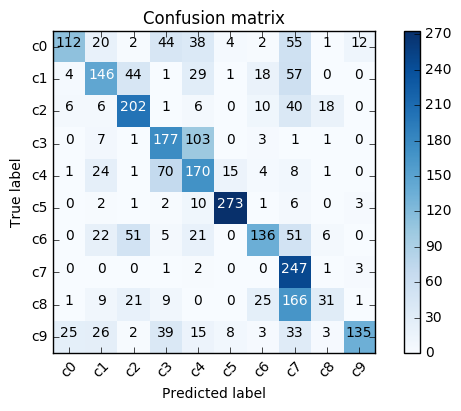

In [16]:
from utils import plot_confusion_matrix
plot_confusion_matrix(cm,sorted(val_batches.class_indices))

## Step 5: Calculate log loss

Like we taked about earlier, accuracy will only take you so far. Think cross entropy.

In [82]:
from sklearn.metrics import log_loss
log_loss(y_true=pd.get_dummies(tru_labels)[7],
         y_pred=predicted_proba[:,7],
         eps=1e-15)

nan

In [116]:
from sklearn.metrics import log_loss
total_logloss=0

for classes in range(10):
    total_logloss = total_logloss+log_loss(y_true=pd.get_dummies(tru_labels)[classes],
                                             y_pred=predicted_proba[:,classes],
                                             eps=0.05)
    print (classes,':',log_loss(y_true=pd.get_dummies(tru_labels)[classes],
                                             y_pred=predicted_proba[:,classes],
                                             eps=0.05))
total_logloss

0 : 0.23059337632
1 : 0.252839861789
2 : 0.190672291031
3 : 0.247053554302
4 : 0.303517832735
5 : 0.088412888378
6 : 0.216844378728
7 : 0.34488250902
8 : 0.298214094944
9 : 0.193138029558


2.3661688168049588

Using default clip values for eps parameter at 1e-15 results in nans. Based on trial and error, eps=0.05 resulted in the lowest log loss for validation. So i need to clip my submissions by/to 0.05

## Step 5: Predict on test set

In [118]:
# load the 3 subject vlidation submission that you had reasonable scores on. Clip it!
test_proba = load_array(results_path + '3_subjects_validation/' + '3subjects_validation_test_preds.dat')
filenames = load_array(results_path + '3_subjects_validation/' + '3subjects_validation_filenames.dat')

## Step 6: Prepare final submission

In [119]:
test_proba_clipped = np.clip(test_proba, 0.05,0.95)

In [123]:
import pandas as pd
result_cols = ['c'+str(i) for i in np.arange(10)]
df_results = pd.concat(
    [pd.DataFrame(filenames, columns=['img']),
    pd.DataFrame(test_proba_clipped,columns=result_cols)], axis=1
)
print (df_results.shape)

(79726, 11)


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,unknown/img_1.jpg,0.050000,0.05,0.05,0.050000,0.050000,0.320872,0.05,0.05,0.147463,0.530289
1,unknown/img_10.jpg,0.224376,0.05,0.05,0.050000,0.705363,0.050000,0.05,0.05,0.051927,0.050000
2,unknown/img_100.jpg,0.950000,0.05,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.050000,0.050000
3,unknown/img_1000.jpg,0.050000,0.05,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.950000,0.050000
4,unknown/img_100000.jpg,0.050000,0.05,0.05,0.599662,0.055303,0.050000,0.05,0.05,0.293674,0.050000


In [124]:
# removing the unknown tag from the image name
df_results['img'] = df_results.img.apply(lambda x:x.split('/')[1])

In [125]:
df_results.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.050000,0.05,0.05,0.050000,0.050000,0.320872,0.05,0.05,0.147463,0.530289
1,img_10.jpg,0.224376,0.05,0.05,0.050000,0.705363,0.050000,0.05,0.05,0.051927,0.050000
2,img_100.jpg,0.950000,0.05,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.050000,0.050000
3,img_1000.jpg,0.050000,0.05,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.950000,0.050000
4,img_100000.jpg,0.050000,0.05,0.05,0.599662,0.055303,0.050000,0.05,0.05,0.293674,0.050000


In [128]:
# save to results
df_results.to_csv(results_path+ '3_subjects_validation/' +'3subjects_validation_clipped_submission3.csv',index=False)

from IPython.display import FileLink
FileLink(results_path+ '3_subjects_validation/' +'3subjects_validation_clipped_submission3.csv')

/home/ubuntu/distracted_driver/data/results/3_subjects_validation/3subjects_validation_clipped_submission3.csv

This results in a score of 1.575. Much better but still needs work. Use lesson 2 logix now.